In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import baltic as bt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
import pandas as pd


mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [8]:
ll=bt.loadNexus("RF-wild-1_1_100.mcc.trees",tip_regex='\|([0-9]+\-[0-9]+\-[0-9]+)') ## treeFile here can alternatively be a path to a local file
ll.treeStats() ## report stats about tree


Tree height: 0.866770
Tree length: 58.796795
strictly bifurcating tree
annotations present

Numbers of objects in tree: 1883 (941 nodes and 942 leaves)



In [22]:
def plot_tree_colored_nodes(tree, filename, traitName, color_list, metadata_translations):
    
    fig,ax = plt.subplots(figsize=(12,15),facecolor='w')

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    dates = []
    for i in np.arange(2021.5,2022.75,0.25):
        dates.append(i)
    #dates = dates_ls[::2]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates]


    branchWidth=1.5 ## default branch width
    tipSize = 20

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            if traitName == "domwildbyb":
                traitValue = metadata_translations[k.traits[traitName]]
            else: 
                traitValue = k.traits[traitName]
            
            traitProb = k.traits[traitName+".prob"]
            base_color=colors[traitValue]
            color_ramp = clr.LinearSegmentedColormap.from_list('custom ', ["#B9B9B9",base_color], N=256)
            c = color_ramp(traitProb)
            s=tipSize

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.005
            
            if traitName == "domwildbyb":
                traitValue = metadata_translations[k.traits[traitName]]
            else: 
                traitValue = k.traits[traitName]

            traitProb = k.traits[traitName+".prob"]
            base_color=colors[traitValue]
            color_ramp = clr.LinearSegmentedColormap.from_list('custom ', ["#B9B9B9", base_color], N=256)
            c = color_ramp(traitProb)
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_list:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title().replace("Domestic","Commercial").replace("Nonhuman-Mammal","Nonhuman\nMammal").replace("bird","Bird").replace("Partially Migratory","Partially\nMigratory"), markersize = 10, markeredgewidth=2)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.set_xlim(2021.6,2022.6)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=24,size=5, width=2,color='grey')
    ax.set_xticks(dates)
    ax.set_xticklabels(["Jul\n2021","Oct\n2021","Jan\n2022","Apr\n2022","Jul\n2022"], fontsize=24)
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, loc='best', bbox_to_anchor=(0.25, 0.3, 0.1, 0.1),prop={'size': 30}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(filename)

    plt.show()

In [23]:
# try instead, clustering into regions and plotting it that way; we could do: west, 2 midwests, 2 souths, northeast
colors = {"Domestic":"#5CA7A4",
          "Wild": "#2664A5",
          "Backyard_bird":"#D1BA56"
         }

uncertainty_color:"#B9B9B9"

color_order_domwildbyb = ["Domestic","Wild","Backyard_bird"]

metadata_translations = {
    "Domestic": "Domestic",
    "Wild": "Wild",
    "backyard_bird": "Backyard_bird",
    "Backyard_bird": "Backyard_bird",
    "domestic":"Domestic",
    "wild":"Wild",
}

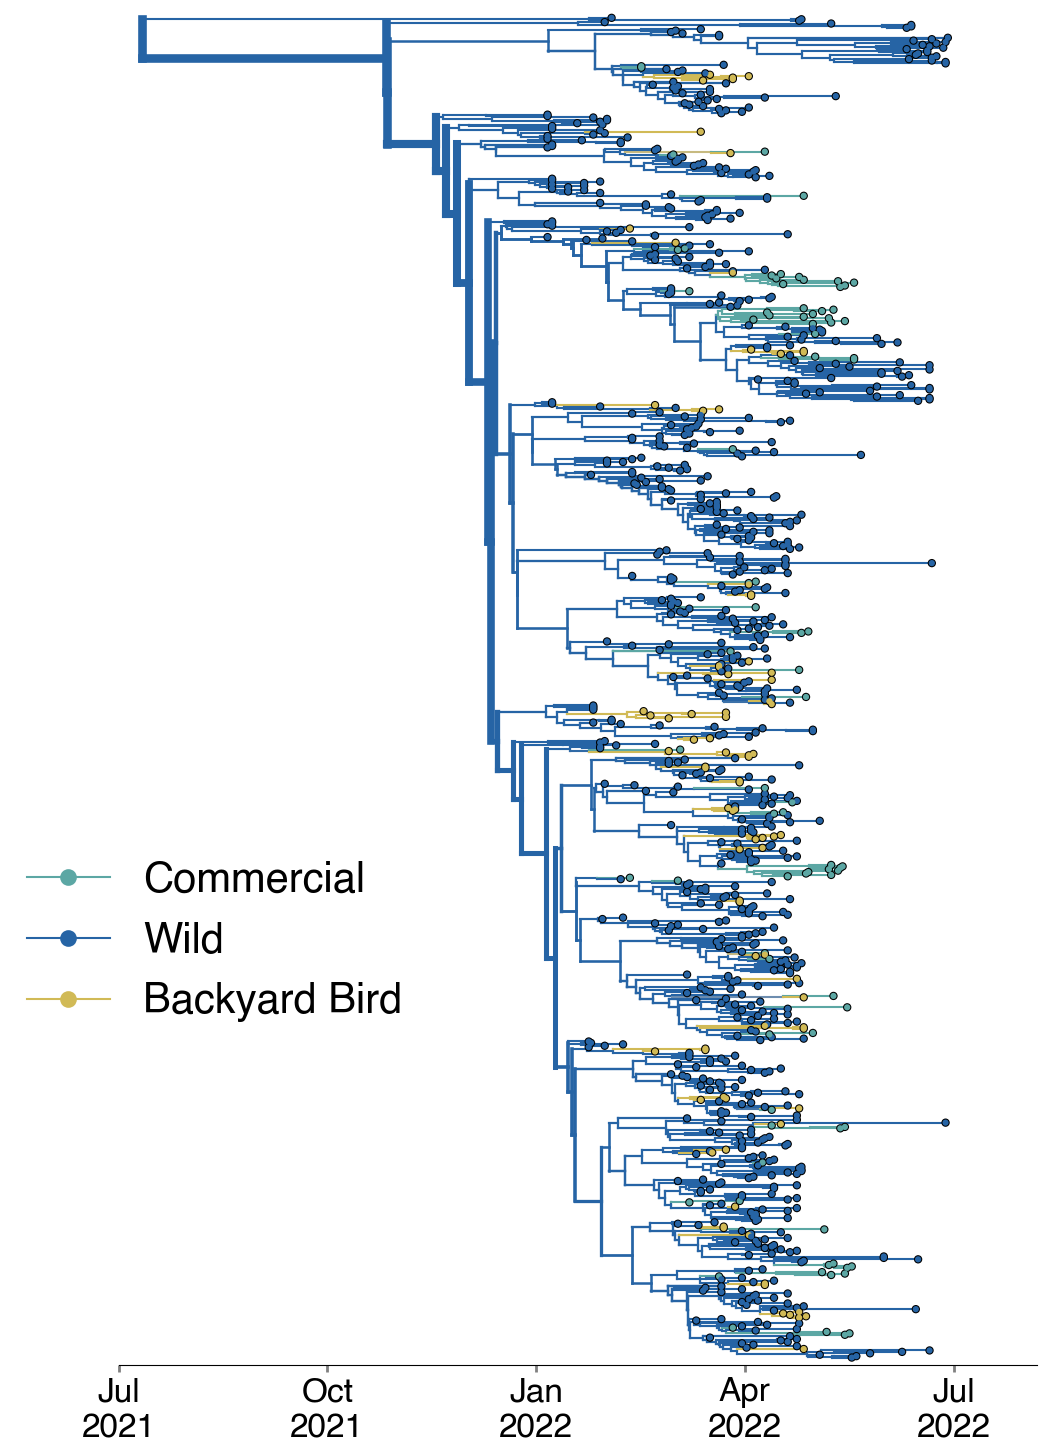

In [24]:
# set output filename
traitName = "domwildbyb.states"
color_list = color_order_domwildbyb
filename = "h5nx-rfwild_1002-"+traitName+".pdf"

plot_tree_colored_nodes(ll, filename, traitName, color_list, metadata_translations)

In [6]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction
def return_height_most_recent_tip(tree):
    all_heights = []
    
    for k in tree.Objects: 
        if k.branchType == "leaf":
            height = k.traits["height"]
            all_heights.append(height)
            
    height_youngest_tip = min(all_heights)
    return(height_youngest_tip)
def return_date_most_recent_tip(tree, height_youngest_tip):
    
    for k in tree.Objects: 
        if k.branchType == "leaf":
            height = k.traits["height"]
            if height == height_youngest_tip:
                date_string = k.name.split("|")[2]
                date_format = '%Y-%m-%d'

                date_obj = dt.strptime(date_string, date_format)
                decimal_date = toYearFraction(date_obj)
                
                return(decimal_date)

In [7]:
height_youngest_tip = return_height_most_recent_tip(ll)
age_youngest_tip = return_date_most_recent_tip(ll, height_youngest_tip)
print(age_youngest_tip)

2022.4930365296805


In [8]:
# get the propbabilty a given node is a given state from the DTA

most_recent_date = age_youngest_tip
def return_node_probs_by_date(tree):
    
    node_probs = {}
    
    for k in tree.Objects: 
        if k.branchType == "node":
            host = k.traits["domwildbyb"]
            host_prob = k.traits["domwildbyb.prob"]
            height = k.traits["height"]
            date = most_recent_date - height
            node_probs[k] = {"host":host, "host_prob":host_prob,"date":date}
            
    return(node_probs)
node_probs = return_node_probs_by_date(ll)
df = pd.DataFrame.from_dict(node_probs, orient="index")
df.head()

,host,host_prob,date
<baltic.baltic.node object at 0x117d39050>,Wild,0.999778,2021.637278
<baltic.baltic.node object at 0x11b122990>,Wild,1.000000,2021.734634
<baltic.baltic.node object at 0x11b122f10>,Wild,1.000000,2021.922045
<baltic.baltic.node object at 0x11b122d10>,Wild,0.999667,2022.042945
<baltic.baltic.node object at 0x11b128190>,Wild,1.000000,2022.060403


In [9]:
import seaborn as sns 
sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='date', y='host_prob', hue='host', palette={'Domestic': "#CEB540", 'Wild': "#274257", 'Backyard_bird':"#CE40A0"}, alpha=0.8)

# Set axis labels
scatter_plot.set(xlabel='\ndate', ylabel='posterior probability internal node\n')

# Set legend title to blank
scatter_plot.legend().set_title("")


scatter_plot.set_title("Internal Node Probabilities - 25% Wild", fontsize=24)
scatter_plot.tick_params(axis='y', labelsize=22)
scatter_plot.tick_params(axis='x', labelsize=22)
scatter_plot.grid(False)
scatter_plot.move_legend()"center right")

plt.savefig('internalnodeprobs-1002.pdf')
# Show the plot
plt.show()


SyntaxError: unmatched ')' (2740957934.py, line 19)

In [10]:
df_high_prob = df[df['host_prob'] >= 0.9]
print(len(df_high_prob))
df_high_prob.head()
df_high_prob.to_csv("df_high_prob-100.csv")

934


In [16]:
ll=bt.loadNexus("transitions_rfallpost/100/MKJ-allposterior-wildbybrf/MKJ-allposterior-wildbybrf/RF-wild-1_1_100_MKJ.domwildbyb.anot.tree",tip_regex='\|([0-9]+\-[0-9]+\-[0-9]+)') ## treeFile here can alternatively be a path to a local file
ll.treeStats() ## report stats about tree


Tree height: 0.965629
Tree length: 56.787675
strictly bifurcating tree
annotations present

Numbers of objects in tree: 1883 (941 nodes and 942 leaves)



2021.5275219597474 Root
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Domestic switc

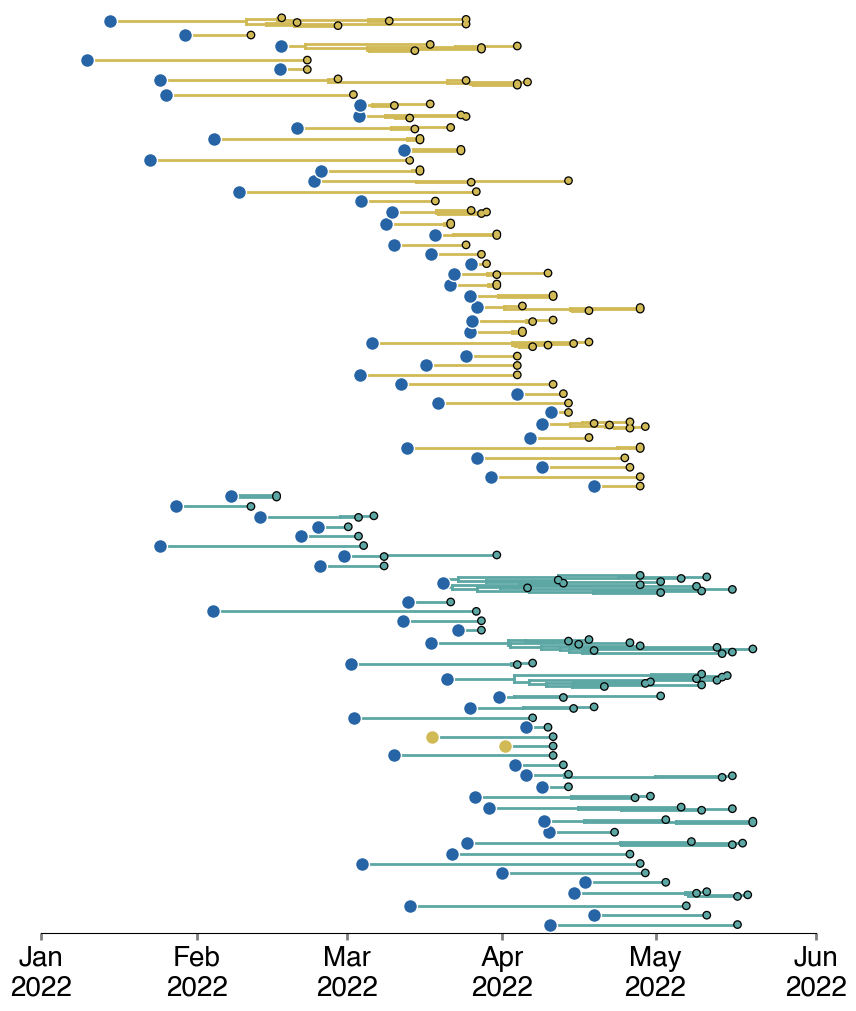

In [19]:
from matplotlib import gridspec
# used code from gytis webpage https://phylo-baltic.github.io/baltic-gallery/basic-exploded-tree-flu/

traitName='domwildbyb.states' ## trait which will be used to disassemble the tree
branchWidth=2

print(ll.root.absoluteTime,ll.root.parent.index)
tree_strings={'Backyard_bird':[],'Domestic':[],'Wild':[]}
subtype_trees={'Backyard_bird':[],'Domestic':[],'Wild':[]}

for l in ll.Objects: ## iterate over branches
    k=l ## branch
    kp=l.parent ## branch's parent
    
    ## get current node's and its parent's trait states
    kloc=k.traits[traitName] ## get branch trait value
    if traitName in k.parent.traits: ## if parent has trait
        kploc=kp.traits[traitName] ## get parental trait value
        kpc=kploc
    else: ## parent does not have trait value, must be at root
        kploc='Wild'
        kpc='Wild'

    kc=kloc ## kc is branch trait value, kpc is branch parent trait value
    
    ## if states do not match
    if kc!=kpc:
        traverse_condition=lambda w:w.traits[traitName]==kc ## only traverse tree for as long as branches are in the branch state
        print('subtree resulting from %s>%s switch, traversing within %s'%(kpc,kc,kc))
        subtree=ll.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
        
        if subtree: ## if the conditional subtree traversal failed because no tips were encountered None is returned
            subtree.traverse_tree() ## traverse subtree
            subtree.sortBranches() ## sort branches
            tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
            subtype_trees[kc].append((kpc,subtree)) ## add parental state and subtree to list

fig = plt.figure(figsize=(10, 12),facecolor='w') ## create figure
gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(gs[0],facecolor='w') ## create axes

tipSize=20
cumulative_y=0

colors = {"Domestic":"#5CA7A4",
          "Wild": "#2664A5",
          "Backyard_bird":"#D1BA56"
         }

x_attr=lambda k: k.absoluteTime
c_func=lambda k: '#5CA7A4' if k.traits[traitName]=='Domestic' else ('#2664A5' if k.traits[traitName] == 'Wild' else '#D1BA56' if k.traits[traitName] == 'Backyard_bird' else '#2664A5')

for subtype in ['Domestic','Backyard_bird']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself
        
        y_attr=lambda k: k.y+cumulative_y ## subtree y values will be offset
        
        loc_tree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour=c_func) ## plot subtree
        loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=tipSize,colour=c_func,zorder=100) ## plot tip points
        
        oriC='#5CA7A4' if origin=='Domestic' else c_func(loc_tree.root.parent) ## origin of subtree
        
        oriX=loc_tree.root.absoluteTime-loc_tree.root.length
        oriY=loc_tree.root.y+cumulative_y
        
        ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        cumulative_y+=loc_tree.ySpan+5 ## increment y displacement
        
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right','left']]

ax.tick_params(axis='x',labelsize=24,size=5, width=2,color='grey')
## no x axis ticks or labels
ax.tick_params(axis='y',size=0)

#ax.grid(axis='x',ls='--')

ax.set_yticklabels([])
ax.set_ylim(-5,cumulative_y)
ax.set_xticks((2022.0, 2022.0833,2022.1639,2022.2466, 2022.3288,2022.4146))
ax.set_xticklabels(["Jan\n2022","Feb\n2022","Mar\n2022","Apr\n2022","May\n2022","Jun\n2022"], fontsize=20)

ax.grid(False)

plt.savefig('ex100-wild2.pdf')
plt.show()

2021.5275219597474 Root
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Backyard_bird switch, traversing within Backyard_bird
subtree resulting from Wild>Domestic switch, traversing within Domestic
subtree resulting from Wild>Domestic switc

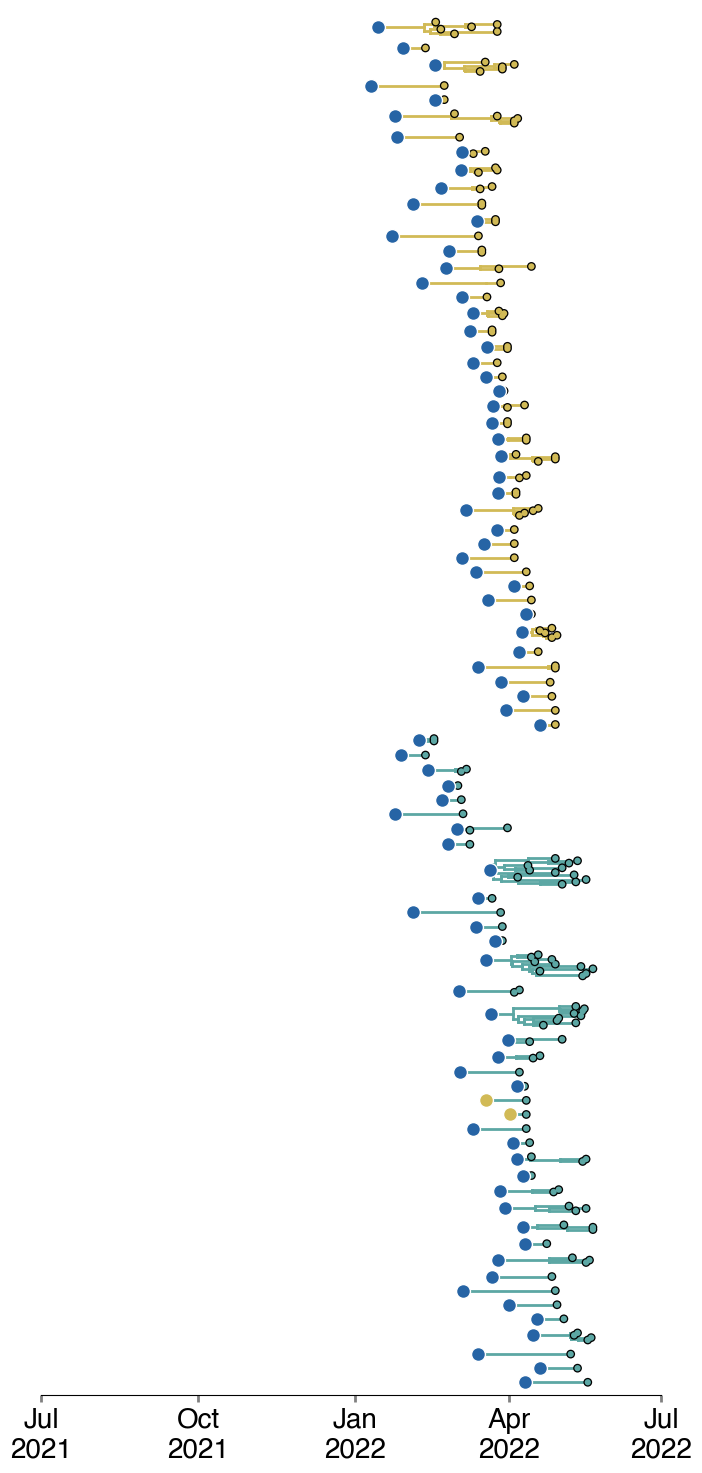

In [21]:
from matplotlib import gridspec
# used code from gytis webpage https://phylo-baltic.github.io/baltic-gallery/basic-exploded-tree-flu/

traitName='domwildbyb.states' ## trait which will be used to disassemble the tree
branchWidth=2

print(ll.root.absoluteTime,ll.root.parent.index)
tree_strings={'Backyard_bird':[],'Domestic':[],'Wild':[]}
subtype_trees={'Backyard_bird':[],'Domestic':[],'Wild':[]}

for l in ll.Objects: ## iterate over branches
    k=l ## branch
    kp=l.parent ## branch's parent
    
    ## get current node's and its parent's trait states
    kloc=k.traits[traitName] ## get branch trait value
    if traitName in k.parent.traits: ## if parent has trait
        kploc=kp.traits[traitName] ## get parental trait value
        kpc=kploc
    else: ## parent does not have trait value, must be at root
        kploc='Wild'
        kpc='Wild'

    kc=kloc ## kc is branch trait value, kpc is branch parent trait value
    
    ## if states do not match
    if kc!=kpc:
        traverse_condition=lambda w:w.traits[traitName]==kc ## only traverse tree for as long as branches are in the branch state
        print('subtree resulting from %s>%s switch, traversing within %s'%(kpc,kc,kc))
        subtree=ll.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
        
        if subtree: ## if the conditional subtree traversal failed because no tips were encountered None is returned
            subtree.traverse_tree() ## traverse subtree
            subtree.sortBranches() ## sort branches
            tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
            subtype_trees[kc].append((kpc,subtree)) ## add parental state and subtree to list

fig = plt.figure(figsize=(8, 18),facecolor='w') ## create figure
gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(gs[0],facecolor='w') ## create axes

tipSize=20
cumulative_y=0

colors = {"Domestic":"#5CA7A4",
          "Wild": "#2664A5",
          "Backyard_bird":"#D1BA56"
         }

x_attr=lambda k: k.absoluteTime
c_func=lambda k: '#5CA7A4' if k.traits[traitName]=='Domestic' else ('#2664A5' if k.traits[traitName] == 'Wild' else '#D1BA56' if k.traits[traitName] == 'Backyard_bird' else '#2664A5')

for subtype in ['Domestic','Backyard_bird']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself
        
        y_attr=lambda k: k.y+cumulative_y ## subtree y values will be offset
        
        loc_tree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour=c_func) ## plot subtree
        loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=tipSize,colour=c_func,zorder=100) ## plot tip points
        
        oriC='#5CA7A4' if origin=='Domestic' else c_func(loc_tree.root.parent) ## origin of subtree
        
        oriX=loc_tree.root.absoluteTime-loc_tree.root.length
        oriY=loc_tree.root.y+cumulative_y
        
        ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        cumulative_y+=loc_tree.ySpan+5 ## increment y displacement
        
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right','left']]

ax.tick_params(axis='x',labelsize=24,size=5, width=2,color='grey')
## no x axis ticks or labels
ax.tick_params(axis='y',size=0)

#ax.grid(axis='x',ls='--')

ax.set_yticklabels([])
ax.set_ylim(-5,cumulative_y)
ax.set_xticks((2021.4959,2021.7479,2022.0,2022.2466,2022.49))
ax.set_xticklabels(["Jul\n2021","Oct\n2021","Jan\n2022","Apr\n2022","Jul\n2022"], fontsize=20)

ax.grid(False)

plt.savefig('explodedtree-100short-wild2.pdf')
plt.show()